### IMPORTING MODULES & LIBRARIES

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import IsolationForest

### DATASET

In [122]:
df = pd.read_csv("air-quality-india.csv")

### EXPLORATORY DATA ANALYSIS

In [123]:
df.head()

,Timestamp,Year,Month,Day,Hour,PM2.5
0,2017-11-07 12:00:00,2017,11,7,12,64.51
1,2017-11-07 13:00:00,2017,11,7,13,69.95
2,2017-11-07 14:00:00,2017,11,7,14,92.79
3,2017-11-07 15:00:00,2017,11,7,15,109.66
4,2017-11-07 16:00:00,2017,11,7,16,116.50


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36192 entries, 0 to 36191
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  36192 non-null  object 
 1   Year       36192 non-null  int64  
 2   Month      36192 non-null  int64  
 3   Day        36192 non-null  int64  
 4   Hour       36192 non-null  int64  
 5   PM2.5      36192 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.7+ MB


In [125]:
df.shape

(36192, 6)

In [126]:
df.describe()

,Year,Month,Day,Hour,PM2.5
count,36192.000000,36192.000000,36192.000000,36192.000000,36192.000000
mean,2019.682278,6.331841,15.716401,11.477840,49.308429
std,1.345011,3.593321,8.859769,6.925088,24.863511
min,2017.000000,1.000000,1.000000,0.000000,7.020000
25%,2019.000000,3.000000,8.000000,5.000000,28.080000
50%,2020.000000,6.000000,16.000000,11.000000,45.730000
75%,2021.000000,10.000000,23.000000,17.000000,64.520000
max,2022.000000,12.000000,31.000000,23.000000,245.630000


In [127]:
df.columns

Index(['Timestamp', 'Year', 'Month', 'Day', 'Hour', 'PM2.5'], dtype='object')

### FEATURE ENGINEERING

In [128]:
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['Time_of_Day'] = df['Hour'].apply(get_time_of_day)

In [129]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(get_season)

In [130]:
def get_aqi_category(level):
    if level<=50:
        return "Good"
    elif level<=100:
        return "Moderate"
    elif level<=150:
        return "Unhealthy for Sensitive Groups"
    elif level<=200:
        return "Unhealthy"
    elif level<=300:
        return "Very Unhealthy"
    else:
        return "Hazardous"
df['AQI_Category'] = df['PM2.5'].apply(get_aqi_category)
        

In [131]:
df.columns

Index(['Timestamp', 'Year', 'Month', 'Day', 'Hour', 'PM2.5', 'Time_of_Day',
       'Season', 'AQI_Category'],
      dtype='object')

### VISUALIZATION

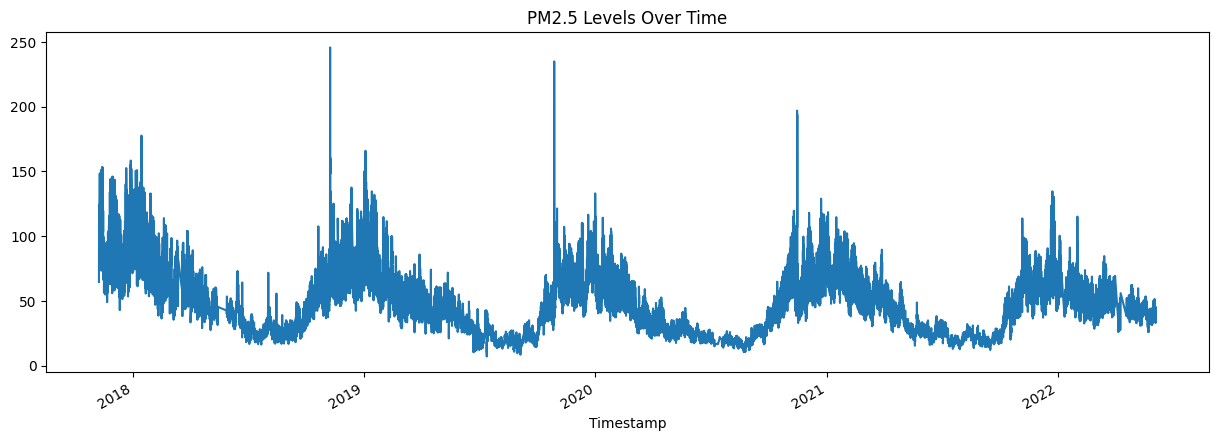

In [132]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp')['PM2.5'].plot(figsize=(15,5))
plt.title('PM2.5 Levels Over Time')
plt.show()

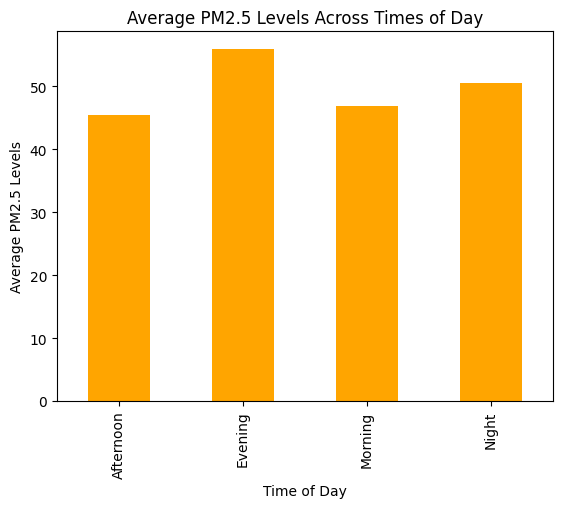

In [133]:
df.groupby('Time_of_Day')['PM2.5'].mean().plot(kind='bar', color='orange')
plt.title('Average PM2.5 Levels Across Times of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average PM2.5 Levels')
plt.show()

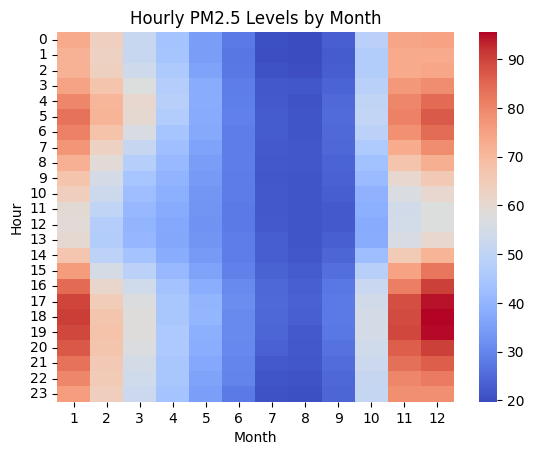

In [135]:
pivot = df.pivot_table(values='PM2.5', index='Hour', columns='Month')
sns.heatmap(pivot, cmap='coolwarm', annot=False)
plt.title('Hourly PM2.5 Levels by Month')
plt.xlabel('Month')
plt.ylabel('Hour')
plt.show()

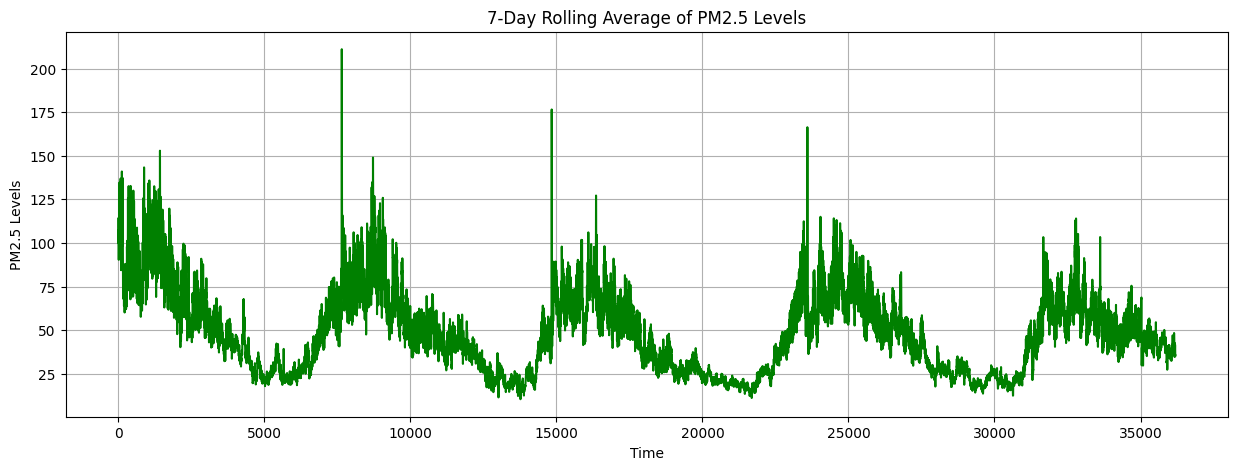

In [136]:
df['PM2.5'].rolling(window=7).mean().plot(figsize=(15, 5), color='green')
plt.title('7-Day Rolling Average of PM2.5 Levels')
plt.xlabel('Time')
plt.ylabel('PM2.5 Levels')
plt.grid(True)
plt.show()

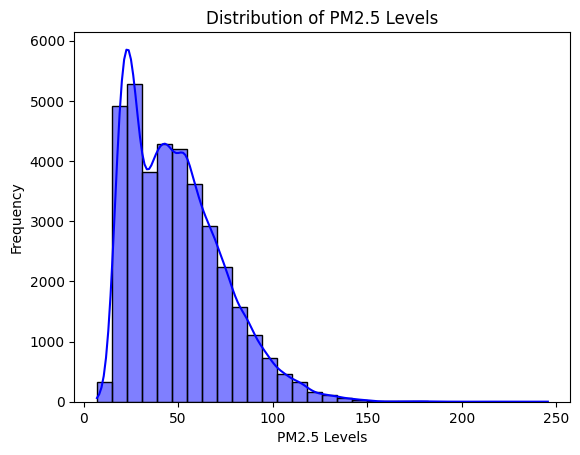

In [139]:
sns.histplot(df['PM2.5'], kde=True, bins=30, color='blue')
plt.title('Distribution of PM2.5 Levels')
plt.xlabel('PM2.5 Levels')
plt.ylabel('Frequency')
plt.show()

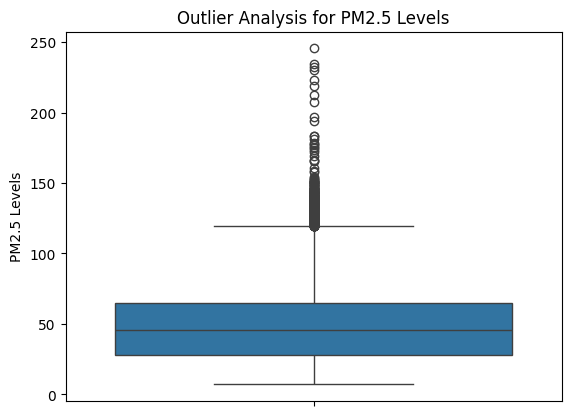

In [140]:
sns.boxplot(y='PM2.5', data=df)
plt.title('Outlier Analysis for PM2.5 Levels')
plt.ylabel('PM2.5 Levels')
plt.show()

## REMOVING OUTLIERS

In [141]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df[['PM2.5']])

df_pure = df[outliers == 1]

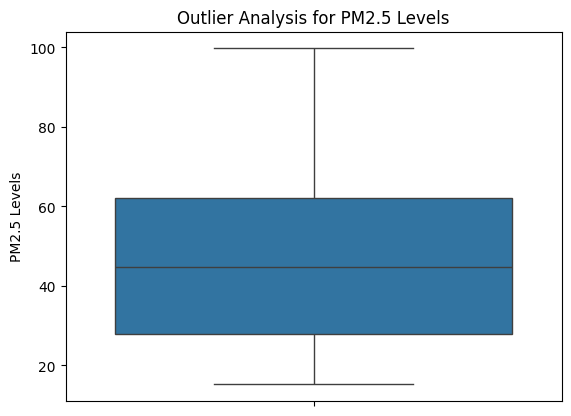

In [142]:
sns.boxplot(y='PM2.5', data=df_pure)
plt.title('Outlier Analysis for PM2.5 Levels')
plt.ylabel('PM2.5 Levels')
plt.show()

## MODEL 1: PREDICTING PM2.5 LEVEL BASED ON YEAR MONTH DAY & HOUR

In [143]:
X_m1 = df_pure[['Year','Month','Day','Hour']]
y_m1 = df_pure['PM2.5']

In [144]:
X_m1_train,X_m1_test,y_m1_train,y_m1_test = train_test_split(X_m1,y_m1,random_state=2529)

In [145]:
m1 = RandomForestRegressor()
m1.fit(X_m1_train,y_m1_train)

RandomForestRegressor()

In [146]:
m1_predict = m1.predict(X_m1_test)

In [147]:
mape_m1 = mean_absolute_percentage_error(y_m1_test,m1_predict)
accuracy_m1 = 100 - 100*mape_m1

In [148]:
accuracy_m1

94.56638701301347

## MODEL 2: PREDICTING PM2.5 LEVEL BASED ON YEAR & MONTH

In [149]:
X_m2 = df_pure[['Year','Month']]
y_m2 = df_pure['PM2.5']

In [150]:
X_m2_train,X_m2_test,y_m2_train,y_m2_test = train_test_split(X_m2,y_m2,random_state=2529)

In [151]:
m2 = RandomForestRegressor()
m2.fit(X_m2_train,y_m2_train)

RandomForestRegressor()

In [152]:
m2_predict = m2.predict(X_m2_test)

In [153]:
mape_m2 = mean_absolute_percentage_error(y_m2_test,m2_predict)
accuracy_m2 = 100 - 100*mape_m2

In [154]:
accuracy_m2

83.53100988694823

## MODEL 3: PREDICTING PM2.5 LEVEL BASED ON YEAR MONTH & HOUR

In [155]:
X_m3 = df_pure[['Year','Month','Hour']]
y_m3 = df_pure['PM2.5']

In [156]:
X_m3_train,X_m3_test,y_m3_train,y_m3_test = train_test_split(X_m3,y_m3,random_state=2529)

In [157]:
m3 = RandomForestRegressor()
m3.fit(X_m3_train,y_m3_train)

RandomForestRegressor()

In [158]:
m3_predict = m3.predict(X_m3_test)

In [159]:
mape_m3 = mean_absolute_percentage_error(y_m3_test,m3_predict)
accuracy_m3 = 100 - 100*mape_m3

In [160]:
accuracy_m3

85.8456798966704

In [161]:
def model_1():
    year = int(input("Year: "))
    month = int(input("Month: "))
    day = int(input("Day: "))
    hour = int(input("Hour: "))
    X_in = np.array([[year, month, day, hour]])
    X_in = pd.DataFrame(X_in,columns=['Year', 'Month', 'Day', 'Hour'])
    y_predicted = m1.predict(X_in)
    return y_predicted,accuracy_m1

In [162]:
def model_2():
    year = int(input("Year: "))
    month = int(input("Month: "))
    X_in = np.array([[year, month, day, hour]])
    X_in = pd.DataFrame(X_in,columns=['Year', 'Month', 'Day'])
    y_predicted = m2.predict(X_in)
    return y_predicted,accuracy_m2

In [163]:
def model_3():
    year = int(input("Year: "))
    month = int(input("Month: "))
    hour = int(input("Hour: "))
    X_in = np.array([[year,month,hour]])
    X_in = pd.DataFrame(X_in,columns=['Year', 'Month', 'Hour'])
    y_predicted = m3.predict(X_in)
    return y_predicted,accuracy_m3

In [ ]:
def program():
    print("What Information do you have?\n1) 1. Year 2. Month 3. Day 4. Hour\n2) 1. Year 2. Month 3. Day\n3) 1. Year 2. Month 3. Hour")
    choice = int(input("Enter your choice: "))
    if choice == 1:
        output,accuracy = model_1()
    elif choice == 2:
        output,accuracy = model_2()
    else:
        output,accuracy = model_3()
    print("Predicted PM2.5 Level on required time will be",output,"with an accuracy of",accuracy)
program()

What Information do you have?
1) 1. Year 2. Month 3. Day 4. Hour
2) 1. Year 2. Month 3. Day
3) 1. Year 2. Month 3. Hour
